### William Chirciu
### CSC 540 Final Project Code

### Importing Libraries

In [1]:
import sys
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from operator import itemgetter
import time
import imblearn

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer, scale, LabelEncoder, OneHotEncoder
from datetime import date

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

### Global Parameters

In [20]:
target_idx=0                                       #Index of Target variable
cross_val=1                                         #Control Switch for CV                                                                                                                                                      
norm_target=0                                       #Normalize target switch
norm_features=0                                  #Normalize features switch
feat_select=0                                      #Control Switch for Feature Selection                                                                                   
fs_type=3                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)                        
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=3                               #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
model = 1
balance = 0

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs

### Load in the data

In [6]:
reader= csv.reader(open('ks-projects-201801.csv',encoding='UTF-8'), delimiter=',', quotechar='"')

#Read Header Line
header=next(reader)

data = []
target = []
row_missing_cnt = 0

for row in reader:
    missing = False
    if row[target_idx]=='' or row[target_idx] == 'live' or row[target_idx] == 'canceled' or row[target_idx] == 'suspended' or row[target_idx] == 'undefined':
        continue
    else:
        target.append(row[target_idx])      #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                
    for j in range(feat_start,len(header)):
            if(row[j]) == '':
                temp.append(float())
                missing = True
                
            else:
                temp.append(row[j])

    #Load temp into Data array
    if missing == True:
        row_missing_cnt = row_missing_cnt + 1
        target.pop()
        continue
    data.append(temp)

  
#Test Print
print(header)
print(len(target),len(data))
print("Rows with missing data removed: " + str(row_missing_cnt))
print('\n')

data_arr=np.asarray(data)
target_np=np.asarray(target)
CampaignLength = []
#Changing data types
for i in data_arr:
    # dates
    split0 = i[7].split(" ")
    i[7] = split0[0]
    
    split1 = i[5].split('/')
    d1 = date(int(split1[2]), int(split1[0]), int(split1[1]))
    
    split2 = i[7].split('/')
    d2 = date(int(split2[2]), int(split2[0]), int(split2[1]))
    
    date_diff = d1 - d2
    CampaignLength.append(date_diff.days)
    
    #convert dollar value strings to float
    i[6] = float(i[6])
    i[8] = float(i[8])
    i[9] = float(i[9])
    i[11] = float(i[11])
    i[12] = float(i[12])
    i[13] = float(i[13])

['state', 'ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
331462 331462
Rows with missing data removed: 213




### Create new Feature CampaignLength 

In [7]:
# Adding new feature CampaignLength (in days)
CampaignLength = np.asarray(CampaignLength)
CampaignLength = np.reshape(CampaignLength, (-1, 1))
data_arr = np.append(data_arr, CampaignLength, 1)
print(header[1:])
print(data_arr[0])

['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
['1000002330' 'The Songs of Adelaide & Abullah' 'Poetry' 'Publishing'
 'GBP' '10/9/2015' '1000.0' '8/11/2015' '0.0' '0.0' 'GB' '0.0' '0.0'
 '1533.95' '59']


### Remove ID, Name,deadline,launched,pledged,backers,usd_pledged,usd_pledged_real, and goal

In [8]:
header = ['state','category', 'main_category', 'currency', 'country', 'usd_goal_real', 'campaign_len_days']
data_np = data_arr[:, [2,3,4,10,13,14]]
print(header[1:])
print(data_np[0])

['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'campaign_len_days']
['Poetry' 'Publishing' 'GBP' 'GB' '1533.95' '59']


### Exploratory Data Analysis

In [9]:
df = pd.DataFrame(data_np, columns=['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'campaign_len_days'])
df.usd_goal_real = df.usd_goal_real.astype(float)
df.campaign_len_days = df.campaign_len_days.astype(float)
df['state'] = target_np
df.head()

category main_category currency country  usd_goal_real  \
0          Poetry    Publishing      GBP      GB        1533.95   
1  Narrative Film  Film & Video      USD      US       30000.00   
2  Narrative Film  Film & Video      USD      US       45000.00   
3           Music         Music      USD      US        5000.00   
4     Restaurants          Food      USD      US       50000.00   

   campaign_len_days       state  
0               59.0      failed  
1               60.0      failed  
2               45.0      failed  
3               30.0      failed  
4               35.0  successful

#### Descriptives

In [10]:
df.describe(include = 'all')

category main_category currency country  usd_goal_real  \
count           331462        331462   331462  331462   3.314620e+05   
unique             159            15       14      22            NaN   
top     Product Design  Film & Video      USD      US            NaN   
freq             18679         56503   261358  261358            NaN   
mean               NaN           NaN      NaN     NaN   4.152286e+04   
std                NaN           NaN      NaN     NaN   1.109279e+06   
min                NaN           NaN      NaN     NaN   1.000000e-02   
25%                NaN           NaN      NaN     NaN   2.000000e+03   
50%                NaN           NaN      NaN     NaN   5.000000e+03   
75%                NaN           NaN      NaN     NaN   1.500000e+04   
max                NaN           NaN      NaN     NaN   1.663614e+08   

        campaign_len_days   state  
count       331462.000000  331462  
unique                NaN       2  
top                   NaN  failed  
freq                  NaN  197611  
mean            33.955910     NaN  
std             12.714067     NaN  
min              1.000000     NaN  
25%             30.000000     NaN  
50%             30.000000     NaN  
75%             36.000000     NaN  
max             92.000000     NaN

In [11]:
df['state'].value_counts()

failed        197611
successful    133851
Name: state, dtype: int64

#### Distribution of failed and successful projects within each country

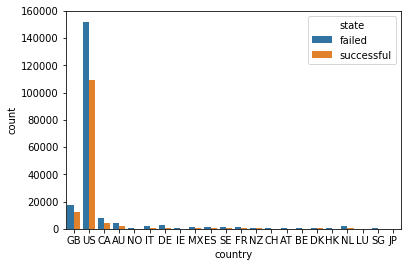

In [12]:
hist = sns.countplot(x="country", hue="state", data=df)

In [13]:
pd.crosstab(df.country, df.state).apply(lambda r: r/r.sum(), axis=1).sort_values('successful', ascending=False)

state      failed  successful
country                      
HK       0.547170    0.452830
US       0.581804    0.418196
GB       0.590296    0.409704
SG       0.607930    0.392070
DK       0.611231    0.388769
FR       0.639683    0.360317
NZ       0.648352    0.351648
SE       0.662691    0.337309
CA       0.665804    0.334196
LU       0.666667    0.333333
JP       0.695652    0.304348
AU       0.696191    0.303809
IE       0.696925    0.303075
BE       0.709369    0.290631
CH       0.713190    0.286810
MX       0.719348    0.280652
NO       0.721649    0.278351
DE       0.727299    0.272701
ES       0.737320    0.262680
NL       0.744090    0.255910
AT       0.779381    0.220619
IT       0.814690    0.185310

#### Distribution of failed and successful projects within each category

In [14]:
pd.crosstab(df.category, df.state).apply(lambda r: r/r.sum(), axis=1).sort_values('successful', ascending=False)

state                 failed  successful
category                                
Chiptune            0.181818    0.818182
Residencies         0.264706    0.735294
Anthologies         0.293080    0.706920
Dance               0.304779    0.695221
Literary Spaces     0.315789    0.684211
Indie Rock          0.321073    0.678927
Classical Music     0.325000    0.675000
Letterpress         0.326087    0.673913
Tabletop Games      0.330211    0.669789
Country & Folk      0.332542    0.667458
Theater             0.340963    0.659037
Typography          0.350515    0.649485
Performances        0.350676    0.649324
Comic Books         0.352587    0.647413
Jazz                0.368060    0.631940
Plays               0.377227    0.622773
Graphic Novels      0.397856    0.602144
Webcomics           0.402337    0.597663
Festivals           0.410323    0.589677
Shorts              0.414341    0.585659
Immersive           0.430976    0.569024
Illustration        0.437370    0.562630
Rock                0.439641    0.560359
Musical             0.443373    0.556627
Art Books           0.450790    0.549210
Camera Equipment    0.451429    0.548571
Comics              0.452958    0.547042
Punk                0.455224    0.544776
Public Art          0.458596    0.541404
Installations       0.465596    0.534404
...                      ...         ...
Crochet             0.768212    0.231788
Farms               0.768642    0.231358
Interactive Design  0.769006    0.230994
Technology          0.769876    0.230124
Apparel             0.770641    0.229359
Childrenswear       0.772727    0.227273
Family              0.775510    0.224490
Events              0.776521    0.223479
Flight              0.785311    0.214689
Bacon               0.790055    0.209945
Live Games          0.793814    0.206186
Nature              0.799197    0.200803
Ready-to-wear       0.804318    0.195682
Embroidery          0.810000    0.190000
Photo               0.810651    0.189349
Couture             0.814978    0.185022
Places              0.815336    0.184664
Farmer's Markets    0.817708    0.182292
Restaurants         0.818579    0.181421
DIY                 0.820059    0.179941
Television          0.820069    0.179931
Hip-Hop             0.825961    0.174039
Action              0.827697    0.172303
Candles             0.854497    0.145503
Software            0.855810    0.144190
Food Trucks         0.862135    0.137865
Video               0.867532    0.132468
Mobile Games        0.893971    0.106029
Web                 0.897192    0.102808
Apps                0.928504    0.071496

[159 rows x 2 columns]

#### Distribution of failed and successful projects within each main category

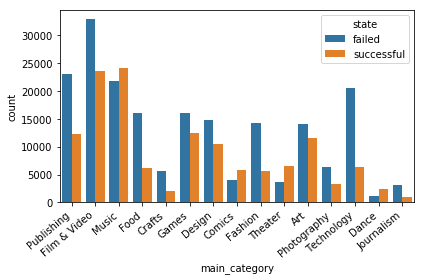

In [15]:
hist = sns.countplot(x="main_category", hue="state", data=df)
hist.set_xticklabels(hist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [16]:
pd.crosstab(df.main_category, df.state).apply(lambda r: r/r.sum(), axis=1).sort_values('successful', ascending=False)

state            failed  successful
main_category                      
Dance          0.345648    0.654352
Theater        0.362039    0.637961
Comics         0.408585    0.591415
Music          0.473701    0.526299
Art            0.551092    0.448908
Games          0.561080    0.438920
Film & Video   0.582111    0.417889
Design         0.584079    0.415921
Publishing     0.652670    0.347330
Photography    0.658892    0.341108
Fashion        0.717154    0.282846
Food           0.724086    0.275914
Crafts         0.729470    0.270530
Journalism     0.756027    0.243973
Technology     0.762146    0.237854

#### Descriptives for usd_goal_real within each class

In [17]:
df.groupby("state")['usd_goal_real'].describe().reset_index()

state     count          mean           std   min     25%     50%  \
0      failed  197611.0  63189.222622  1.436066e+06  0.15  2500.0  7500.0   
1  successful  133851.0   9535.701785  2.796708e+04  0.01  1300.0  3840.0   

       75%           max  
0  20000.0  1.663614e+08  
1  10000.0  2.015609e+06

#### Descriptives for campaign_len_days within each class

In [18]:
df.groupby("state")['campaign_len_days'].describe().reset_index()

state     count       mean        std  min   25%   50%   75%   max
0      failed  197611.0  35.174585  13.175366  1.0  30.0  30.0  40.0  92.0
1  successful  133851.0  32.156719  11.772305  1.0  30.0  30.0  34.0  92.0

### Converting to proper data types for Model Training

In [19]:
# Label Encoding
number = LabelEncoder()
target_np = number.fit_transform(target_np.astype('str'))
data_np[:,4] = data_np[:,4].astype('float')
data_np[:,5] = data_np[:,5].astype('float')
data_np[:,0] = number.fit_transform(data_np[:,0].astype('str'))
data_np[:,1] = number.fit_transform(data_np[:,1].astype('str'))
data_np[:,2] = number.fit_transform(data_np[:,2].astype('str'))
data_np[:,3] = number.fit_transform(data_np[:,3].astype('str'))
data_np = data_np.astype('float')

## ONE HOT ENCODING
#target_np = target_np.astype('float')
#onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3])
#data_np = onehotencoder.fit_transform(data_np).toarray()
#data_np = np.asarray(data_np)
print(target_np)
print(data_np[0])

[0 0 0 ... 0 0 0]
[ 108.     12.      5.      9.   1533.95   59.  ]


### Rebalance Data

In [21]:
# Test our Models on Imbalanced data
from imblearn.over_sampling import SMOTE

if balance == 1:
    smote = SMOTE(ratio='minority')
    data_train, target_train = smote.fit_sample(data_train, target_train)

### Data Normalization

In [22]:
if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

### Feature Selection

In [23]:
#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if model == 1:
            clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=3,min_samples_leaf = 50, criterion='gini', random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if model == 2:
            clf = GradientBoostingClassifier(n_estimators=50,loss='deviance',learning_rate=0.1,max_depth=8,
                                   min_samples_split=3300, min_samples_leaf = 50, random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Gradient Boost: ')
        if model == 3:
            clf = AdaBoostClassifier(n_estimators=100,base_estimator=None,learning_rate=0.1,random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Ada Boost: ')
        if model == 4:
            clf= MLPClassifier(activation='logistic',solver='adam',alpha=0.0001,max_iter=1000,
                      hidden_layer_sizes=(10,),random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Neural Network: ')
        if model == 5:
            clf = SVC(kernel='linear',gamma='scale',C=1.0,probability=True,random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - SVM: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if model == 1:
            clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=3,min_samples_leaf = 50, criterion='gini', random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Random Forest: ')
        if model == 2:
            clf = GradientBoostingClassifier(n_estimators=50,loss='deviance',learning_rate=0.1,max_depth=8,
                                   min_samples_split=3300, min_samples_leaf = 50, random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Gradient Boost: ')
        if model == 3:
            clf = AdaBoostClassifier(n_estimators=100,base_estimator=None,learning_rate=0.1,random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Ada Boost: ')
        if model == 4:
            clf= MLPClassifier(activation='logistic',solver='adam',alpha=0.0001,max_iter=1000,
                      hidden_layer_sizes=(10,),random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Neural Network: ')
        if model == 5:
            clf = SVC(kernel='linear',gamma='scale',C=1.0,probability=True,random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - SVM: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:
        #Univariate Feature Selection - Chi-squared
        sel=SelectKBest(chi2, k=k_cnt)
        fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
        print ('Univariate Feature Selection - Chi2: ')
        sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i + feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)

### Train Scikit Models and Evaluate Using 5-Fold Cross Validation

In [24]:
scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}


start_ts=time.time()
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                 min_samples_split=3300, min_samples_leaf=50, max_features=None, random_state=rand_st)
scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("D-tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                        #Only works with binary classes, not multiclass
scores_AUC= scores['test_roc_auc']
print("D-tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts,"\n")

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=3, min_samples_leaf = 50,criterion='gini', random_state=rand_st)
scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                        #Only works with binary classes, not multiclass
scores_AUC= scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts,"\n")

start_ts=time.time()
clf = GradientBoostingClassifier(n_estimators=100,loss='deviance',learning_rate=0.1,max_depth=8,
                                   min_samples_split=3300, min_samples_leaf = 50, random_state=rand_st)
scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Gradient Boost Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                        #Only works with binary classes, not multiclass
scores_AUC= scores['test_roc_auc']
print("Gradient Boost AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts,"\n")

start_ts=time.time()
clf = AdaBoostClassifier(n_estimators=100,base_estimator=None,learning_rate=0.1,random_state=rand_st)
scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Ada Boost Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                        #Only works with binary classes, not multiclass
scores_AUC= scores['test_roc_auc']
print("Ada Boost AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts,"\n")

start_ts=time.time()
clf= MLPClassifier(activation='relu',solver='adam',alpha=0.0001,max_iter=100,
                      hidden_layer_sizes=(10,10),random_state=rand_st)
scores = cross_validate(clf, scale(data_np), target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                        #Only works with binary classes, not multiclass
scores_AUC= scores['test_roc_auc']
print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts,"\n")

D-tree Acc: 0.67 (+/- 0.00)
D-tree AUC: 0.71 (+/- 0.01)
CV Runtime: 8.112807512283325 

Random Forest Acc: 0.68 (+/- 0.00)
Random Forest AUC: 0.73 (+/- 0.00)
CV Runtime: 71.91690397262573 

Gradient Boost Acc: 0.69 (+/- 0.00)
Gradient Boost AUC: 0.74 (+/- 0.00)
CV Runtime: 560.6864874362946 

Ada Boost Acc: 0.64 (+/- 0.00)
Ada Boost AUC: 0.68 (+/- 0.00)
CV Runtime: 220.8064284324646 

Neural Network Acc: 0.66 (+/- 0.01)
Neural Network AUC: 0.69 (+/- 0.01)
CV Runtime: 332.48481941223145 



### Data Balancing with SMOTE (keep 10% unbalanced data for validation)

In [35]:
#Create 10% validation set to test balanced data models on
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.10,stratify = target_np)

In [36]:
# Balance data using oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
data_train, target_train = smote.fit_sample(data_train, target_train)

In [37]:
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=3300, min_samples_leaf=50, max_features=None, random_state=rand_st)
model = clf.fit(data_train,target_train)
predictions = clf.predict(data_test)
print("Decision Tree Accuracy:  " + str(accuracy_score(target_test,predictions)))                                                                                                       #Only works with binary classes, not multiclass
print("Decision Tree AUC: " + str(roc_auc_score(target_test,predictions)) + '\n')                           

clf = RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=3, min_samples_leaf = 50,criterion='gini', random_state=rand_st)                        
model = clf.fit(data_train,target_train)
predictions = clf.predict(data_test)
print("Random Forest Accuracy:  " + str(accuracy_score(target_test,predictions)))                                                                                                       #Only works with binary classes, not multiclass
print("Random Forest AUC: " + str(roc_auc_score(target_test,predictions)) + '\n')

clf = GradientBoostingClassifier(n_estimators=50,loss='deviance',learning_rate=0.1,max_depth=8,min_samples_split=3300, min_samples_leaf = 50, random_state=rand_st)                          
model = clf.fit(data_train,target_train)
predictions = clf.predict(data_test)
print("Gradient Boosting Accuracy:  " + str(accuracy_score(target_test,predictions)))                                                                                                       #Only works with binary classes, not multiclass
print("Gradient Boosting AUC: " + str(roc_auc_score(target_test,predictions)) + '\n')

clf = AdaBoostClassifier(n_estimators=100,base_estimator=None,learning_rate=0.1,random_state=rand_st)
model = clf.fit(data_train,target_train)
predictions = clf.predict(data_test)
print("Ada Boost Accuracy:  " + str(accuracy_score(target_test,predictions)))                                                                                                       #Only works with binary classes, not multiclass
print("Ada Boost AUC: " + str(roc_auc_score(target_test,predictions)) + '\n')                         


Decision Tree Accuracy:  0.6514918393821462
Decision Tree AUC: 0.6473305212113807

Random Forest Accuracy:  0.6666666666666666
Random Forest AUC: 0.6638058113818165

Gradient Boosting Accuracy:  0.6685371225148581
Gradient Boosting AUC: 0.6643739827821074

Ada Boost Accuracy:  0.6178839714001267
Ada Boost AUC: 0.627221405778446



In [38]:
# Needed to do Neural Networks seperate so as to scale the data beforehand
data_train_nn, data_test_nn, target_train_nn, target_test_nn = train_test_split(scale(data_np), target_np, test_size=0.10, stratify = target_np)
data_train_nn, target_train_nn = smote.fit_sample(data_train_nn, target_train_nn)
clf= MLPClassifier(activation='relu',solver='adam',alpha=0.0001,max_iter=100,hidden_layer_sizes=(10,10),random_state=rand_st)
model = clf.fit(data_train_nn,target_train_nn)
predictions = clf.predict(data_test_nn)
print("Neural Network Accuracy:  " + str(accuracy_score(target_test_nn,predictions)))                                                                                                       #Only works with binary classes, not multiclass
print("Neural Network AUC: " + str(roc_auc_score(target_test_nn,predictions)))


Neural Network Accuracy:  0.6362868434549129
Neural Network AUC: 0.6309143091167411
